# Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
import joblib

In [2]:
# Ensemble Methods
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse

In [14]:
!pip install pandas_profiling

     |████████████████████████████████| 133kB 803kB/s eta 0:00:01
     |████████████████████████████████| 614kB 3.6MB/s eta 0:00:01
     |████████████████████████████████| 225kB 2.9MB/s eta 0:00:01
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=8746af07bc32c1b89691c16d5e56a49a2a4bc9cb9c1a610745c1915137354ec2
  Stored in directory: /Users/xmpuspus/Library/Caches/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27086 sha256=f354f5cc372d44a3e77dc0509adc39c9bc79e87e8ed7f34d47b09f8b2ff2b445
  Stored in directory: /Users/xmpuspus/Library/Caches/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for confuse: filename=confuse-1.0.0-cp37-none-any.whl size=17486 sha256=b840ecdcb24fcec002208264298c4a9a6ad9b91e3af409505a6ecf7dc3f08759
  Stored in directory: /Users/xmpuspus/Library/Caches/pip/wheels/b0/b2

In [15]:
import pandas_profiling as pp

# Load Data

In [18]:
data = pd.read_csv('data/nyc-rolling-sales.csv')

In [19]:
data.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [24]:
report = pp.ProfileReport(data, title='Data Assessment')

In [25]:
report.to_file('data_assessment.html')

# Clean Data

In [6]:
### Clean Data
# Convert to float
data['SALE PRICE'] = pd.to_numeric(data['SALE PRICE'], errors='coerce')
data['SALE PRICE'] = data['SALE PRICE'].fillna(0)

data['GROSS SQUARE FEET'] = pd.to_numeric(data['GROSS SQUARE FEET'], errors='coerce')
data['LAND SQUARE FEET'] = pd.to_numeric(data['LAND SQUARE FEET'], errors='coerce')

# Convert to date
data['SALE DATE'] = pd.to_datetime(data['SALE DATE'], errors='coerce')


# Remove 5th and 95th percentile tails
zero = 0
fifth = data['SALE PRICE'].describe(np.arange(0.05, 1, 0.05)).T['15%']
ninetyfifth = data['SALE PRICE'].describe(np.arange(0.05, 1, 0.05)).T['95%']
data = data[(data['SALE PRICE'] > zero) &
             (data['SALE PRICE'] <= ninetyfifth)].copy()

# Handle Missing Values by Dropping (for now)
data.dropna(inplace=True)


In [7]:
data.shape

(36128, 22)

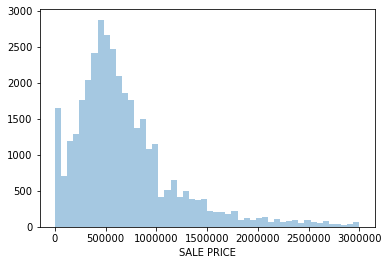

In [8]:
sns.distplot(data['SALE PRICE'], kde=False)

In [9]:
dep_var = 'SALE PRICE'
cat_names = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT',
              'BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE']
cont_names = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'RESIDENTIAL UNITS', 
              'COMMERCIAL UNITS']

# Feature Engineering

In [10]:
# Multihot encode categorical variables
df_cat = pd.get_dummies(data[cat_names].astype(str))

# Reassign numerical to diff df
df_cont = data[cont_names]

# Normalize numerical features
df_cont_norm = (df_cont-df_cont.min())/(df_cont.max()-df_cont.min())

# Concatenate features
X = pd.concat([df_cat, df_cont_norm], axis=1)

# Get dependent variable and store as different df series
y = np.log(data[dep_var])

In [11]:
df_cont.corr().style.background_gradient('coolwarm', axis=None)

,LAND SQUARE FEET,GROSS SQUARE FEET,RESIDENTIAL UNITS,COMMERCIAL UNITS
LAND SQUARE FEET,1,0.791965,0.654991,0.0291856
GROSS SQUARE FEET,0.791965,1,0.870247,0.0237757
RESIDENTIAL UNITS,0.654991,0.870247,1,0.00917148
COMMERCIAL UNITS,0.0291856,0.0237757,0.00917148,1


In [12]:
X.shape, y.shape

((36128, 560), (36128,))

# Modelling

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

# model = RandomForestRegressor(n_estimators=300, random_state=42)
model = GradientBoostingRegressor(n_estimators=300, random_state=42, )

# Fit Model
%time model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
rmse_score = np.sqrt(mse(y_pred, y_test))

In [ ]:
rmse_score

In [ ]:
rmse_score_train = np.sqrt(mse(y_pred_train, y_train))
rmse_score_train

# AutoML

In [ ]:
# !pip install tpot;
from tpot import TPOTRegressor

In [ ]:
gen_num = 5
max_tot_time = 30
max_eval_time = 3
pop_size = 10
verbose = 2

In [ ]:
import os
import shutil

datadir = './pipelines'
if not os.path.exists(datadir):
    os.makedirs(datadir)

tpot = TPOTRegressor(generations=gen_num, max_time_mins=max_tot_time, 
                      max_eval_time_mins=max_eval_time, population_size=pop_size, verbosity = verbose, memory = 'auto',
                     periodic_checkpoint_folder='pipelines/', warm_start = True)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

In [ ]:
pd.DataFrame(dict(list(tpot.evaluated_individuals_.items()))).T\
.replace([np.inf, -np.inf], np.nan)\
.dropna()\
.drop('generation', axis = 1)\
.sort_values('internal_cv_score', ascending = False)\
.head()